In [ ]:
import torch
from torchvision import transforms
from score_models import ScoreModel, EnergyModel, NCSNpp, MLP, DDPM
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image

In [ ]:
imag_names = [i for i in os.listdir("/home/mjybarth/scratch/PetImages/Cat/") if i.endswith('.jpg')]

In [ ]:
for i in tqdm(range(len(imag_names)), ):
    img = Image.open(os.path.join("/home/mjybarth/scratch/PetImages/Cat/", imag_names[i]))
    if len(np.asarray(img).shape) != 3:
        print(imag_names[i])
        print(np.asarray(img).shape)

100%|██████████| 12470/12470 [00:14<00:00, 848.22it/s]


(374, 500, 3)


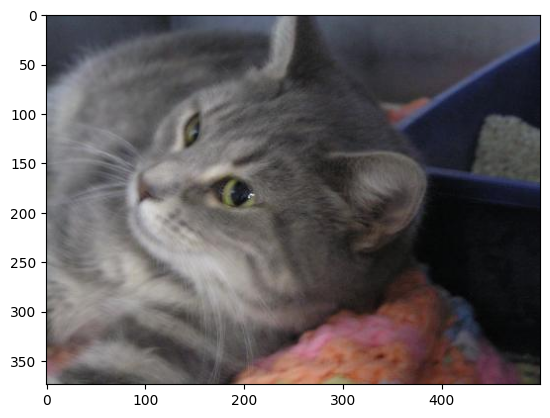

In [ ]:
from PIL import Image
img = Image.open("/home/mjybarth/scratch/PetImages/Cat/3655.jpg")
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(np.asarray(img))

In [ ]:
IMAGE_SIZE = (64, 64, 3)
BATCH_SIZE = 64
DEVICE = "cuda"

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale()
    ]),
}

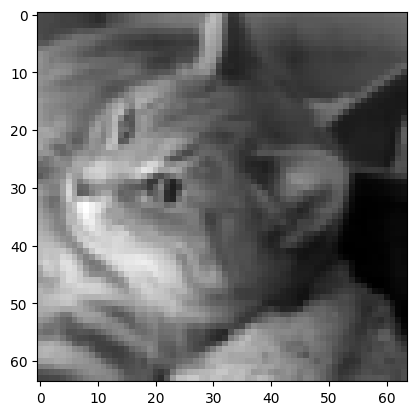

In [ ]:
plt.imshow(data_transforms["train"](img)[0], cmap = "gray")

In [ ]:
class CatsDogsDataset(Dataset):
    """Custom Dataset for loading cat images"""

    def __init__(self, img_dir, transform=None, device=DEVICE):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.transform = transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale()
    ])
        self.device = device
        

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img.to(self.device)

    def __len__(self):
        return len(self.img_names)

In [ ]:
train_dataset = CatsDogsDataset(img_dir='/home/mjybarth/scratch/PetImages/Cat/', 
                                transform=data_transforms['train'])

In [ ]:
train_dataset.__len__()

12470

In [ ]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=64,
                          drop_last=False,
                          shuffle=True)

In [ ]:
iterable = iter(train_loader)

In [ ]:
len(train_loader)

195

In [ ]:
real_batch = next(iter(train_loader))

In [ ]:
real_batch.shape

torch.Size([64, 1, 64, 64])

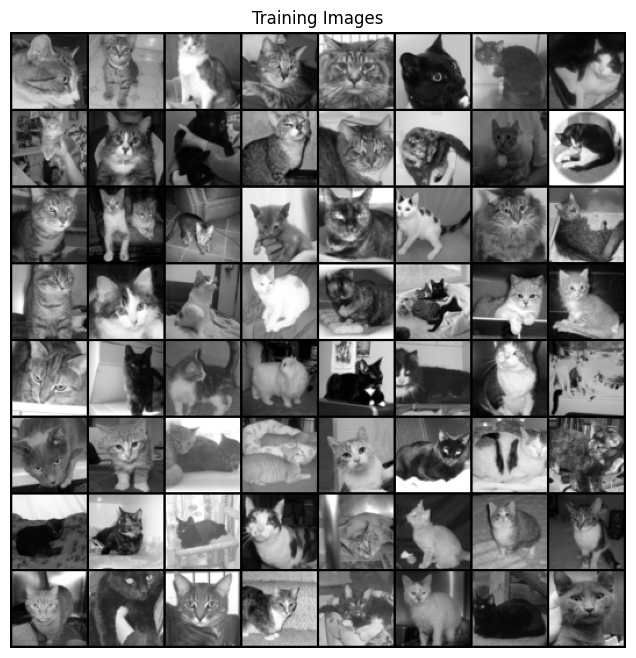

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64].cpu(), 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

In [47]:
# B is the batch size
# C is the input channels
# dimensions are the spatial dimensions (e.g. [28, 28] for MNIST)

B = 64
C = 1
dimensions = (64, 64)
checkpoints_directory = "/home/mjybarth/scratch/CHECKPOINTS"

# Create a ScoreModel instance with Yang Song's NCSN++ architecture and the VESDE
net = NCSNpp(channels=C, dimensions=len(dimensions), nf=128, ch_mult=[2, 2, 2, 2])
model = ScoreModel(model=net, sigma_min=1e-2, sigma_max=50, device="cuda")
# ... or the VPSDE
model = ScoreModel(model=net, beta_min=1e-2, beta_max=20, device="cuda")

Using the Variance Exploding SDE
Using the Variance Preserving SDE


In [48]:
# Train the score model, and save its weight in checkpoints_directory
model.fit(train_dataset, epochs=1, batch_size=B, learning_rate=1e-4, checkpoints_directory="/home/mjybarth/scratch/CHECKPOINTS3")

Epoch 1 | Cost: 4.2e+02 |: 100%|██████████| 1/1 [01:33<00:00, 93.86s/it]

Finished training after 0.026 hours.


[423.86540151742787]

In [44]:
model.model.nf

128

In [ ]:
sample = model.sample(shape = [8, 1, 64, 64], steps = 1000)

Sampling from the prior | t = 0.0 | sigma = 4.5e-03| scale ~ 2.1e+00: 100%|██████████| 1000/1000 [00:18<00:00, 54.99it/s]


In [ ]:
sample.shape

torch.Size([8, 1, 64, 64])

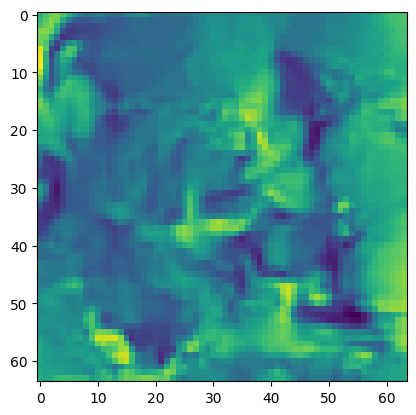

In [ ]:
plt.imshow(sample.to("cpu").numpy()[5, 0])

In [ ]:
# Generate samples from the trained model (steps is the number of Euler-Maruyama steps)
samples = model.sample(shape=[1, B, *dimensions], steps=1000)

# Generate posterior samples given a likelihood score function (with a specified guidance factor, defaults to 1.)
samples = model.sample([1, B, *dimensions], N, likelihood_score_fn, guidance_factor)

# Compute the score for a given input
score = model.score(t, x)

# Compute the likelihood for a given input
score = model.likelihood(t, x)

# Initialise the score model and its neural network from a path to a checkpoint directory 
score = ScoreModel(checkpoints_directory=checkpoints_directory)

Loaded checkpoint 1 of CHECKPOINTS


0it [00:00, ?it/s]


Finished training after 0.000 hours.


Sampling from the prior | t = 1.0 | sigma = 1.0e+00| scale ~ 1.0e+00:   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 8, 64, 64] to have 1 channels, but got 8 channels instead

## Euclidean Distance

In [62]:
maxed = 0
for i in tqdm(range(2500), ):
    img1 = Image.open(os.path.join("/home/mjybarth/scratch/PetImages/Cat/", imag_names[i]))
    img2 = Image.open(os.path.join("/home/mjybarth/scratch/PetImages/Cat/", imag_names[i+1]))
    numpy1 = data_transforms["train"](img1)[0].numpy()
    numpy2 = data_transforms["train"](img2)[0].numpy()
    dist_squared = np.sum(np.square(numpy1 - numpy2))
    if dist_squared > maxed:
        maxed = dist_squared

100%|██████████| 2500/2500 [00:06<00:00, 404.98it/s]


In [63]:
np.sqrt(maxed)

91.261215

In [64]:
np.sqrt(dist_squared)

43.612907